# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn


import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")


import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
from polcanet import LinearDecoder, PolcaNet, PolcaNetLoss
from polcanet.example_aencoders import ConvEncoder

In [4]:
import polcanet.polcanet_reports as report

In [5]:
import utils as ut
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="MNIST_dataset",
    description="POLCA-Net on MNIST dataset",
    random_seed=random_seed,
)
report.set_save_fig(True)
report.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {report.get_save_fig()}, saving in path: {report.get_save_path()}")

Saving Images: True, saving in path: /data/deploy/polcanet/examples/notebooks/MNIST_dataset


### Load dataset

In [6]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="data/MNIST", train=True, download=True, transform=None)
mnist_testset = MNIST(root="data/MNIST", train=False, download=True, transform=None)

In [7]:
train_dataset = mnist_trainset.data.reshape(-1, 28, 28) / 255.0
eval_dataset = mnist_testset.data.reshape(-1, 28, 28) / 255.0
y = mnist_trainset.targets.numpy()
y_test = mnist_testset.targets.numpy()
X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 (60000, 28, 28),
 (10000, 28, 28),
 (60000,),
 (10000,))

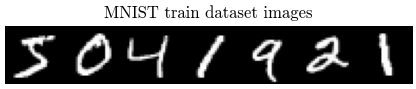

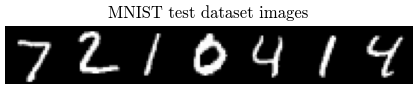

In [8]:
report.set_fig_prefix("sin_train")
ut.plot_train_images(X, "MNIST train dataset images",cmap="gray", n=7)
report.set_fig_prefix("sin_test")
ut.plot_train_images(X_test, "MNIST test dataset images",cmap="gray", n=7)

### Fit standard sklearn PCA

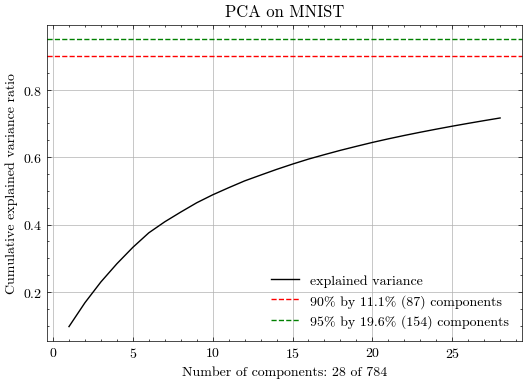

In [9]:
n_components = 28 #  int(np.prod(X.shape[1:]) // 25)
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca = ut.get_pca(X,n_components=n_components,title="PCA on MNIST",ax=axs,)
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [10]:
N = X[0].shape[0]
M = X[0].shape[1]

In [11]:
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=512,
    num_layers=5,
    act_fn=act_fn,
    bias = False,
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.0,  # variance reduction loss
    device=device,
    center=True,
    factor_scale=True,
)

report.save_text(str(model),"model.txt")
print(model)

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): SiLU()
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=128, out_features=112, bias=True)
        (12): SiLU()
        (13): Linear(in_features=112, out_features=28, bias=True)
      )
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=28, out_features=512, bias=False)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bi

In [12]:
model.to(device)
model.train_model(data=X,batch_size=2*512, num_epochs=5000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.006863
Reconstruction Loss: 0.004316
Orthogonality Loss: 0.001436
Center of Mass Loss: 0.0005674
Variance Distribution Loss: 0


0.00686282979450741

In [13]:
model.train_model(data=X,batch_size=2*512, num_epochs=5000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.004985
Reconstruction Loss: 0.003635
Orthogonality Loss: 0.0009684
Center of Mass Loss: 0.0001903
Variance Distribution Loss: 0


0.004984830332509542

In [14]:
model.train_model(data=X, batch_size=2*512, num_epochs=5000, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.004692
Reconstruction Loss: 0.003521
Orthogonality Loss: 0.0008671
Center of Mass Loss: 0.0001502
Variance Distribution Loss: 0


0.0046921768225729465

## Evaluate results

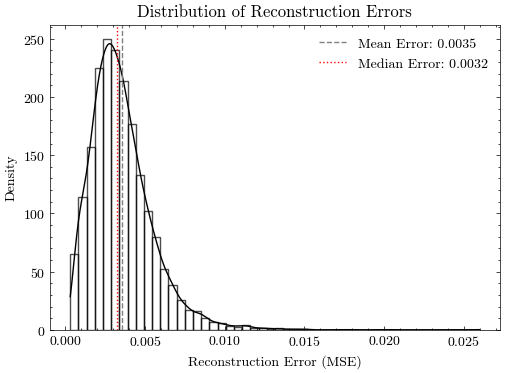

Mean Reconstruction Error: 0.0035
Median Reconstruction Error: 0.0032
Min Reconstruction Error: 0.0003
Max Reconstruction Error: 0.0260


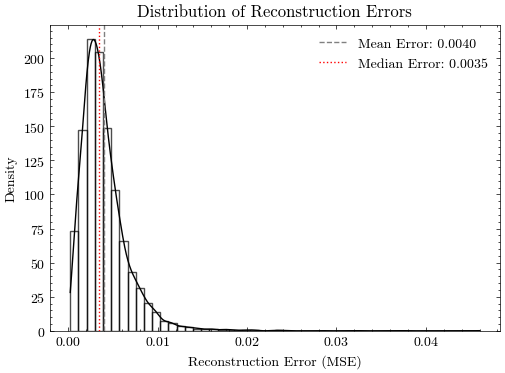

Mean Reconstruction Error: 0.0040
Median Reconstruction Error: 0.0035
Min Reconstruction Error: 0.0002
Max Reconstruction Error: 0.0460


In [15]:
report.set_fig_prefix("train")
report.analyze_reconstruction_error(model, X)
report.set_fig_prefix("test")
report.analyze_reconstruction_error(model, X_test)

In [16]:
latents, reconstructed = model.predict(X)

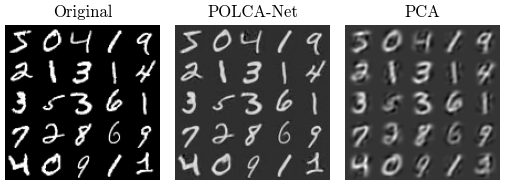

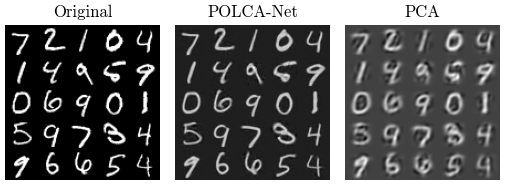

In [31]:
# Assuming images are properly defined as before
images = X[0:25]
report.set_fig_prefix("train")
ut.plot_reconstruction_comparison(model,pca,images,cmap="gray",nrow=5)
images = X_test[0:25]
report.set_fig_prefix("test")
ut.plot_reconstruction_comparison(model,pca,images,cmap="gray",nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0000
    - Max cosine similarity: 0.0855
    - Min cosine similarity: -0.0886
    


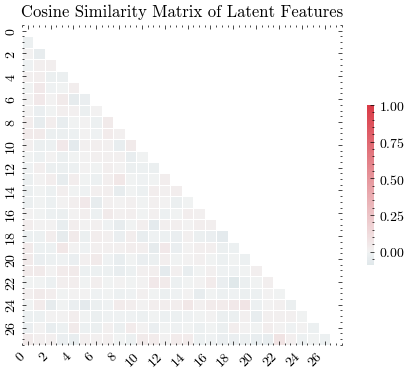

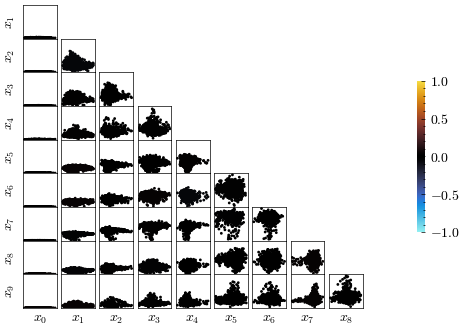


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0004
    - Max cosine similarity: 0.0964
    - Min cosine similarity: -0.0925
    


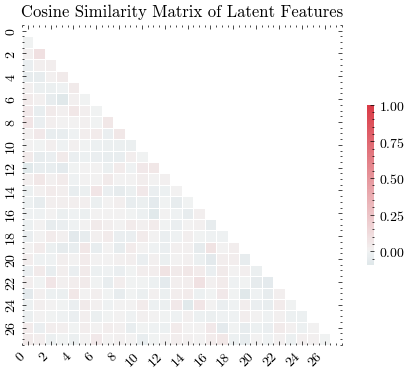

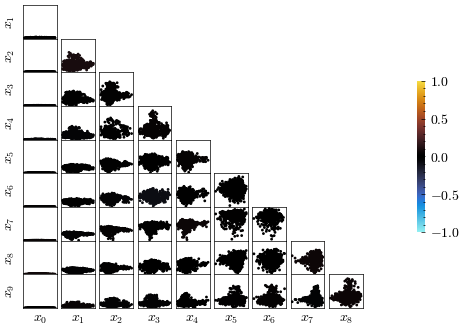

In [18]:
report.set_fig_prefix("train")
report.orthogonality_test_analysis(model, X)
report.set_fig_prefix("test")
report.orthogonality_test_analysis(model, X_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0124
    - Variance fit to exponential distribution (sum of squared differences):
     0.1936
    


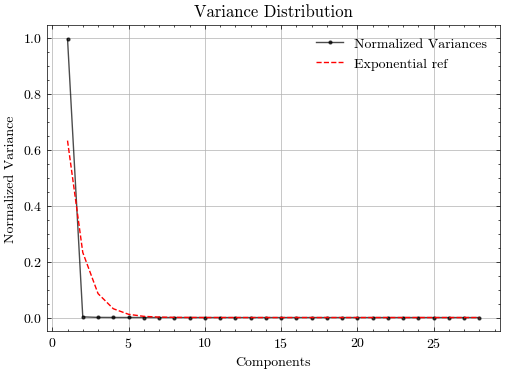

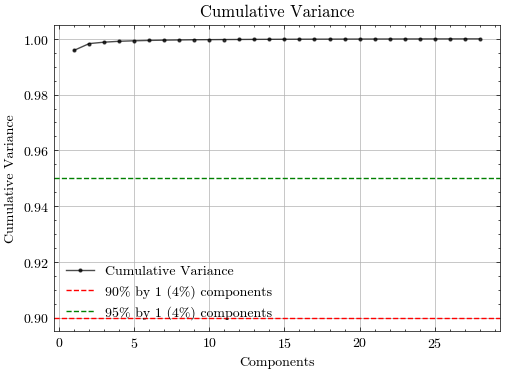

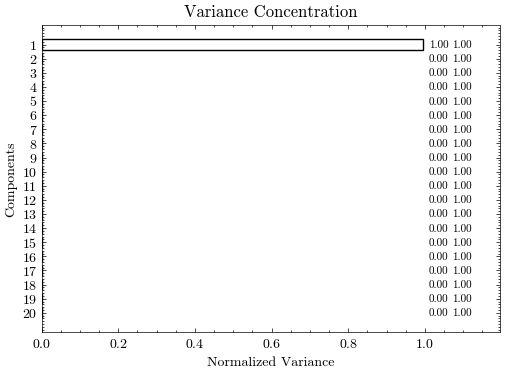


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.0127
    - Variance fit to exponential distribution (sum of squared differences):
     0.1936
    


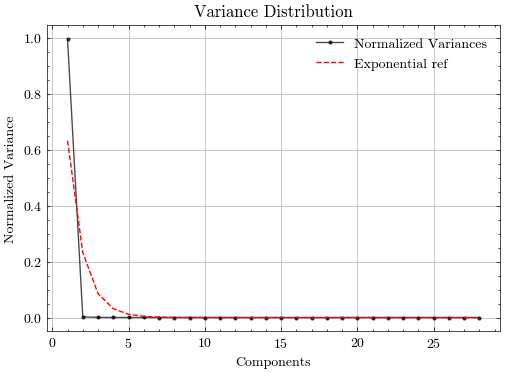

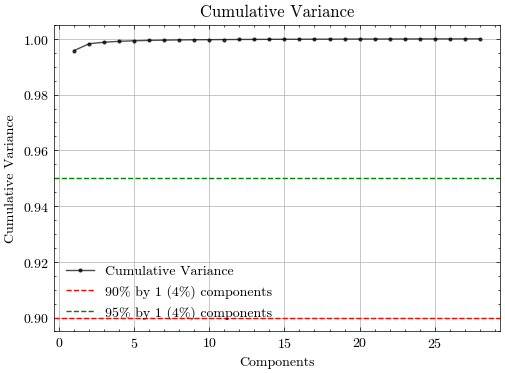

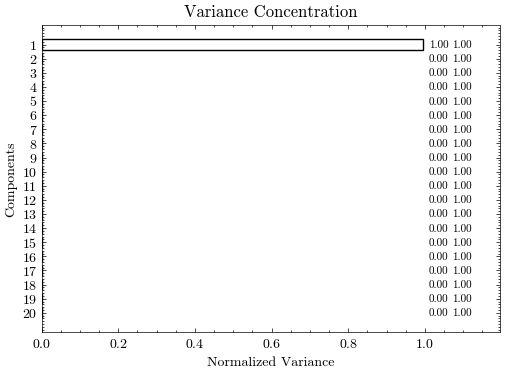

In [19]:
report.set_fig_prefix("train")
report.variance_test_analysis(model, X)
report.set_fig_prefix("test")
report.variance_test_analysis(model, X_test)

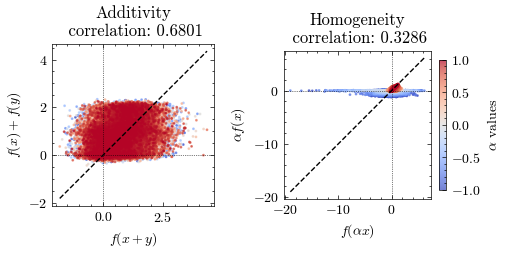

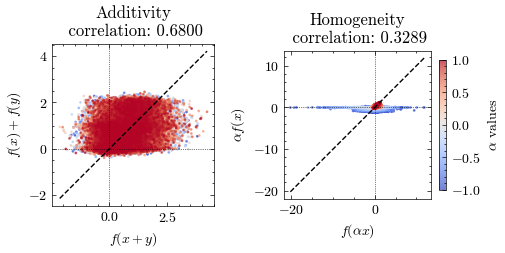

In [20]:
report.set_fig_prefix("train")
report.linearity_tests_analysis(model, X)
report.set_fig_prefix("test")
report.linearity_tests_analysis(model, X_test)

In [40]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label,alpha=0.7, s=1)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [41]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

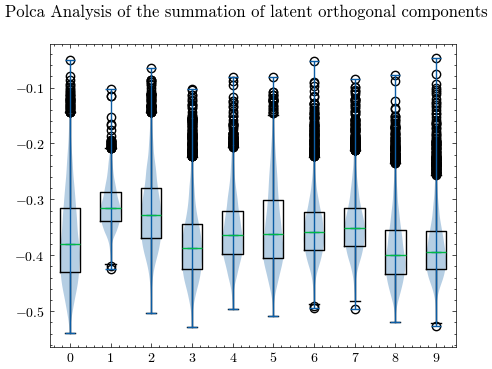

In [23]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [24]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

## Test Classification with two components on PCA vs POLCA Net

In [25]:
_ = ut.make_classification_report(model, pca, X, y)

(42000, 28) (18000, 28)
(42000, 28) (18000, 28)


/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Performance Metrics DataFrame:


/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Accuracy           Precision              Recall  \
Transformation             PCA     POLCA       PCA     POLCA       PCA   
Classifier                                                               
Gaussian Naive Bayes  0.846167  0.888667  0.853094  0.894083  0.846167   
Linear SVM            0.904500  0.931333  0.906316  0.933618  0.904500   
Logistic Regression   0.875889  0.911056  0.879952  0.913998  0.875889   
Perceptron            0.807944  0.869778  0.847576  0.885110  0.807944   
Ridge Classifier      0.816167  0.875667  0.819957  0.879704  0.816167   

                                F1-Score            
Transformation           POLCA       PCA     POLCA  
Classifier                                          
Gaussian Naive Bayes  0.888667  0.847523  0.889741  
Linear SVM            0.931333  0.904112  0.931264  
Logistic Regression   0.911056  0.875840  0.910937  
Perceptron            0.869778  0.811797  0.869781  
Ridge Classifier      0.875667  0.813628  0.874752


Wilcoxon Signed-Rank Test Results DataFrame:


,Wilcoxon Test Statistic,P-Value,Significant (p < 0.05)
Accuracy,0.0,0.0625,No better method
Precision,0.0,0.0625,No better method
Recall,0.0,0.0625,No better method
F1-Score,0.0,0.0625,No better method


In [26]:
experiment_data = {
    "MNIST": (
        X_test,
        model,
        pca,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,Normalized Mean Squared Error,Peak Signal-to-Noise Ratio,Structural Similarity Index
Method,,,
POLCA MNIST,0.0368,72.9465,0.9999
PCA MNIST,0.1771,65.7605,0.9994
